In [2]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pickle
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import sac
from sac import SAC_Agent
import pylab as plt
from importlib import reload
import torch 

Using device: cpu


In [3]:
env_name = "Pendulum-v1"
#env_name = "LunarLander-v2"
log_interval = 20         # print avg reward in the interval
max_episodes = 500 # max training episodes
max_timesteps = 2000         # max timesteps in one episode
save_interval = 500
train_iter = 32      # update networks for given batched after every episode
random_seed = 42

In [4]:
def save_statistics(rewards,lengths,q_losses,pi_losses,temperature_loss,env_name,random_seed,episode):
    with open(f"./results/SAC_{env_name}-s{random_seed}-e{episode}-stat.pkl", 'wb') as f:
        pickle.dump({"rewards" : rewards, "lengths": lengths, "train": train_iter,
                        "pi_losses": pi_losses, "q_losses": q_losses,
                        "temperature_loss":temperature_loss}, f)

In [5]:
def run_sac_agent_in_environment(env_name=env_name,log_interval=log_interval,save_interval=save_interval,max_episodes=max_episodes,max_timesteps=max_timesteps,train_iter=train_iter,random_seed=random_seed):
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)

    env = gym.make(env_name)

    if env_name == "LunarLander-v2":
        env = gym.make(env_name,continuous=True)
    else:
        env = gym.make(env_name)
    agent = SAC_Agent(env.observation_space, env.action_space)
    rewards = []
    lengths = []
    q_losses = []
    policy_losses = []
    temperature_losses = []
    timestep = 0

    for episode in range(1,max_episodes+1):
        ob, _info = env.reset()
        total_reward=0
        for t in range(max_timesteps):
            timestep +=1
            done = False
            a = agent.act(ob)
            (ob_new,reward,done,trunc,_info) = env.step(a)
            total_reward += reward
            agent.store_transition((ob,a,reward,ob_new,done))
            ob=ob_new
            if done or trunc: break

        q_loss,pi_loss,temperature_loss = agent.train(train_iter)
            
        q_losses.extend(q_loss)
        policy_losses.extend(pi_loss)
        temperature_losses.extend(temperature_loss)
        rewards.append(total_reward)
        lengths.append(t)

        if episode % save_interval ==0:
            print("########### Save checkpoint ################")
            torch.save(agent.get_networks_states(),f'./results/SAC_{env_name}-e{episode}-t{train_iter}-s{random_seed}.pth')
            save_statistics(rewards,lengths,q_losses,policy_losses,temperature_losses,env_name,random_seed,episode)

        if episode % log_interval == 0:
            avg_reward = np.mean(rewards[-log_interval:])
            avg_length = int(np.mean(lengths[-log_interval:]))
            print('Episode {} \t avg length: {} \t reward: {}'.format(episode, avg_length, avg_reward))
    save_statistics(rewards,lengths,q_losses,policy_losses,temperature_losses,env_name,random_seed,episode)

In [10]:
torch.manual_seed(random_seed)
np.random.seed(random_seed)
env = gym.make(env_name)

agent = SAC_Agent(env.observation_space, env.action_space)
torch.save(agent.get_networks_states(),f'./results/SAC_{env_name}_{0}-t{train_iter}-s{random_seed}.pth')

In [5]:
run_sac_agent_in_environment(env_name=env_name,log_interval=log_interval,save_interval=save_interval,max_episodes=max_episodes,max_timesteps=max_timesteps,train_iter=train_iter,random_seed=random_seed)

Episode 20 	 avg length: 199 	 reward: -1306.3261150395458
Episode 40 	 avg length: 199 	 reward: -1207.3542175490254
Episode 60 	 avg length: 199 	 reward: -1074.1441449704846
Episode 80 	 avg length: 199 	 reward: -563.5908470229593
Episode 100 	 avg length: 199 	 reward: -193.01629587521464
Episode 120 	 avg length: 199 	 reward: -148.23745724919044
Episode 140 	 avg length: 199 	 reward: -232.98278970195992
Episode 160 	 avg length: 199 	 reward: -199.08812415235786
Episode 180 	 avg length: 199 	 reward: -135.0525371697671
Episode 200 	 avg length: 199 	 reward: -192.31622492084702
Episode 220 	 avg length: 199 	 reward: -203.96786762430185
Episode 240 	 avg length: 199 	 reward: -170.40882874655807
Episode 260 	 avg length: 199 	 reward: -127.99538425783108
Episode 280 	 avg length: 199 	 reward: -154.68327484996183
Episode 300 	 avg length: 199 	 reward: -208.32553998918502
Episode 320 	 avg length: 199 	 reward: -152.8139435309599
Episode 340 	 avg length: 199 	 reward: -146.22

## Helper Functions

In [6]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)    

In [7]:
def run(env, agent:SAC_Agent, n_episodes=100):
    rewards = []
    observations = []
    actions = []
    agent.eval
    for ep in range(1, n_episodes+1):
        ep_reward = 0
        state, _info = env.reset()
        for t in range(2000):
            action = agent.act(state)
            state, reward, done, _trunc, _info = env.step(action)
            observations.append(state)
            actions.append(action)
            ep_reward += reward
            if done or _trunc:
                break
        rewards.append(ep_reward)
        ep_reward = 0
    print(f'Mean reward: {np.mean(rewards)}')
    observations = np.asarray(observations)
    actions = np.asarray(actions)
    return observations, actions, rewards

# SAC

In [10]:
with open(f"./results/SAC_{env_name}-s{random_seed}-e{max_episodes}-stat.pkl", 'rb') as f:
    data = pickle.load(f)
    rewards = np.asarray(data["rewards"])
    q_losses =  np.asarray(data["q_losses"])
    pi_losses  = np.asarray(data["pi_losses"])
    temperature_losses = np.asarray(data["temperature_loss"])

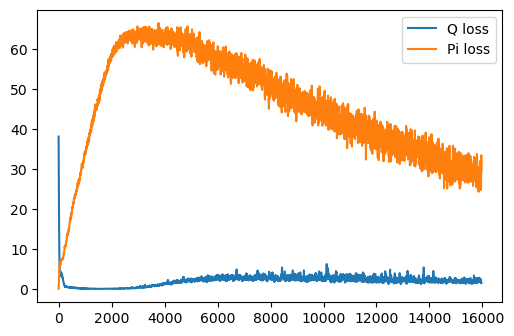

In [11]:
fig=plt.figure(figsize=(6,3.8))
plt.plot(running_mean(q_losses,10),label=f"Q loss")
plt.plot(running_mean(pi_losses,10),label=f"Pi loss")
#plt.plot(running_mean(temperature_losses,10),label=f"Temp loss")
plt.legend()

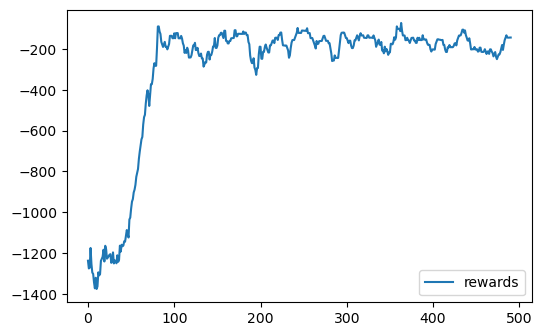

In [12]:
fig=plt.figure(figsize=(6,3.8))
plt.plot(running_mean(rewards,10),label=f"rewards")
plt.legend()

## value function

In [8]:
def plot_Q_function(q_function, observations, actions, plot_dim1=0, plot_dim2=2,
                    label_dim1="cos(angle)", label_dim2="angular velocity"):
    plt.rcParams.update({'font.size': 12})
    observations_tensor = torch.from_numpy(observations)
    actions_tensor = torch.from_numpy(actions)
    values =q_function.get_min_Q_value(observations_tensor,actions_tensor).detach().numpy()
    
    fig = plt.figure(figsize=[10,8])
    ax = fig.add_subplot()
    surf = ax.scatter (observations[:,plot_dim1], observations[:,plot_dim2],  c = values, cmap=cm.coolwarm)
    ax.set_xlabel(label_dim1)
    ax.set_ylabel(label_dim2)

    return fig

In [14]:
env = gym.make(env_name)

In [15]:
checkpoint = f"./results/SAC_{env_name}-e{int(max_episodes/save_interval)*save_interval}-t{train_iter}-s{random_seed}.pth"
print(checkpoint)

./results/SAC_Pendulum-v1-e500-t32-s42.pth


In [16]:
agent  = sac.SAC_Agent(env.observation_space, env.action_space)
#print(torch.load(checkpoint)[1])
agent.load_network_states(torch.load(checkpoint))
agent.eval()

Agent now in evaluation Mode


In [17]:
observations, actions, rewards = run(env,agent,100)

Mean reward: -151.93940641632184


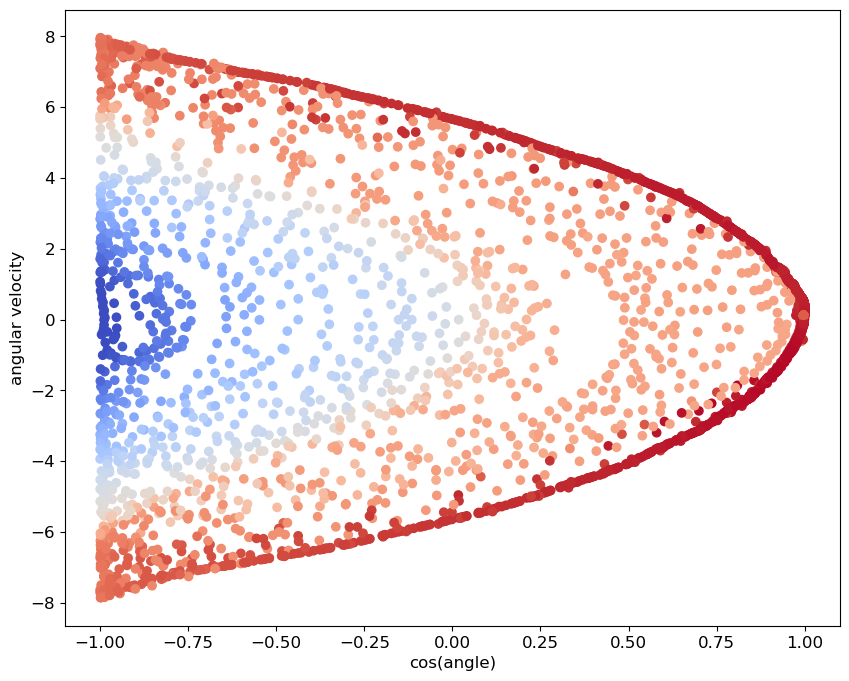

In [18]:
_ = plot_Q_function(agent.critic,observations,actions)

In [19]:
env = gym.make(env_name, render_mode="human")
agent = sac.SAC_Agent(env.observation_space, env.action_space)
agent.load_network_states(torch.load(checkpoint))
agent.eval()
#TODO implement agent working in environment
observation, info = env.reset(seed=42)
for _ in range(500):
   action = agent.act(observation)
   observation, reward, terminated, truncated, info = env.step(action)

   if terminated or truncated:
      observation, info = env.reset()

Agent now in evaluation Mode


In [20]:
env.close()

## HalfCheetah

In [21]:
env_name = "HalfCheetah-v4"
log_interval = 20         # print avg reward in the interval
max_episodes = 2000 # max training episodes
max_timesteps = 2000         # max timesteps in one episode
save_interval = 500
train_iter = 32      # update networks for given batched after every episode
random_seed = 42
reload(sac)

Using device: cpu


<module 'sac' from 'c:\\Users\\Moritz Christ\\Documents\\Uni\\23Wintersemester\\RL\\Project\\RL\\RL_Agent\\SAC\\sac.py'>

In [ ]:
run_sac_agent_in_environment(env_name=env_name,log_interval=log_interval,save_interval=save_interval,max_episodes=max_episodes,max_timesteps=max_timesteps,train_iter=train_iter,random_seed=random_seed)

In [ ]:
with open(f"./results/SAC_{env_name}-s{random_seed}-e{int(max_episodes/save_interval)*save_interval}-stat.pkl", 'rb') as f:
    data = pickle.load(f)
    rewards = np.asarray(data["rewards"])
    q_losses =  np.asarray(data["q_losses"])
    pi_losses  = np.asarray(data["pi_losses"])
    temperature_losses = np.asarray(data["temperature_loss"])

In [ ]:
fig=plt.figure(figsize=(6,3.8))
plt.plot(running_mean(rewards,10))

In [ ]:
checkpoint = f"./SAC_{env_name}-e{int(max_episodes/save_interval)*save_interval}-t{train_iter}-s{random_seed}.pth"
env = gym.make(env_name, render_mode="human")
agent = sac.SAC_Agent(env.observation_space, env.action_space)
agent.eval()
#TODO implement agent working in environment
observation, info = env.reset(seed=42)
for _ in range(1000):
   action = agent.act(observation)
   observation, reward, terminated, truncated, info = env.step(action)

   if terminated or truncated:
      observation, info = env.reset()

In [ ]:
env.close()

## Lunar Lander

In [9]:
#env_name = "Pendulum-v1"
env_name = "LunarLander-v2"
log_interval = 20         # print avg reward in the interval
max_episodes = 500 # max training episodes
max_timesteps = 2000         # max timesteps in one episode
save_interval = 500
train_iter = 32      # update networks for given batched after every episode
random_seed = 42

In [10]:
run_sac_agent_in_environment(env_name=env_name,log_interval=log_interval,save_interval=save_interval,max_episodes=max_episodes,max_timesteps=max_timesteps,train_iter=train_iter,random_seed=random_seed)

Episode 20 	 avg length: 118 	 reward: -166.11591334694313
Episode 40 	 avg length: 104 	 reward: -235.00766689888005
Episode 60 	 avg length: 153 	 reward: -176.71724637091802
Episode 80 	 avg length: 269 	 reward: -208.16322717262128
Episode 100 	 avg length: 616 	 reward: -151.93828665398766
Episode 120 	 avg length: 894 	 reward: -114.35890344178691
Episode 140 	 avg length: 999 	 reward: -77.48522814328648
Episode 160 	 avg length: 999 	 reward: -77.9915056737259
Episode 180 	 avg length: 999 	 reward: -98.49581047157116
Episode 200 	 avg length: 909 	 reward: -85.52758568092521
Episode 220 	 avg length: 952 	 reward: -88.16049536644024
Episode 240 	 avg length: 999 	 reward: -107.00827520928208
Episode 260 	 avg length: 999 	 reward: -88.2558002371283
Episode 280 	 avg length: 999 	 reward: -86.38761978577561
Episode 300 	 avg length: 999 	 reward: -98.72949457815605
Episode 320 	 avg length: 999 	 reward: -87.11097030094147
Episode 340 	 avg length: 999 	 reward: -85.48506758839

In [11]:
with open(f"./results/SAC_{env_name}-s{random_seed}-e{int(max_episodes/save_interval)*save_interval}-stat.pkl", 'rb') as f:
    data = pickle.load(f)
    rewards = np.asarray(data["rewards"])
    q_losses =  np.asarray(data["q_losses"])
    pi_losses  = np.asarray(data["pi_losses"])
    temperature_losses = np.asarray(data["temperature_loss"])

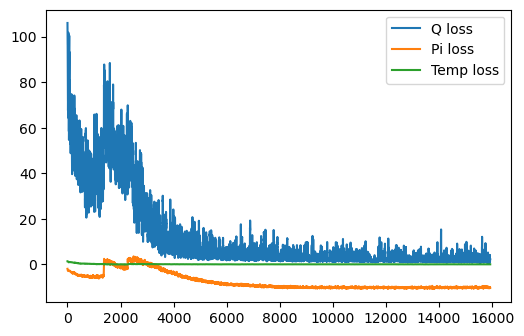

In [12]:
fig=plt.figure(figsize=(6,3.8))
plt.plot(running_mean(q_losses,10),label=f"Q loss")
plt.plot(running_mean(pi_losses,10),label=f"Pi loss")
plt.plot(running_mean(temperature_losses,10),label=f"Temp loss")
plt.legend()

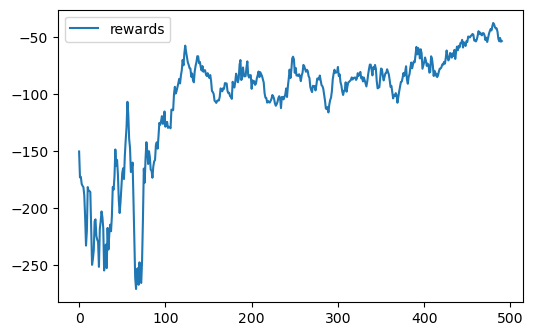

In [13]:
fig=plt.figure(figsize=(6,3.8))
plt.plot(running_mean(rewards,10),label=f"rewards")
plt.legend()

In [14]:
checkpoint = f"./results/SAC_{env_name}-e{int(max_episodes/save_interval)*save_interval}-t{train_iter}-s{random_seed}.pth" 
env = gym.make(env_name, render_mode="human",continuous=True)
agent = sac.SAC_Agent(env.observation_space, env.action_space)
agent.load_network_states(torch.load(checkpoint))
agent.eval()
#TODO implement agent working in environment
observation, info = env.reset(seed=4)
for _ in range(1200):
   action = agent.act(observation)
   observation, reward, terminated, truncated, info = env.step(action)

   if terminated or truncated:
      observation, info = env.reset()

Agent now in evaluation Mode


In [15]:
env.close()

### Mountain Car Continuous

In [ ]:
env_name = "MountainCarContinuous-v0"
log_interval = 20         # print avg reward in the interval
max_episodes = 500 # max training episodes
max_timesteps = 2000         # max timesteps in one episode
save_interval = 500
train_iter = 32      # update networks for given batched after every episode
random_seed = 42

In [ ]:
run_sac_agent_in_environment(env_name=env_name,log_interval=log_interval,save_interval=save_interval,max_episodes=max_episodes,max_timesteps=max_timesteps,train_iter=train_iter,random_seed=random_seed)

In [ ]:
with open(f"./results/SAC_{env_name}-s{random_seed}-e{int(max_episodes/save_interval)*save_interval}-stat.pkl", 'rb') as f:
    data = pickle.load(f)
    rewards = np.asarray(data["rewards"])
    q_losses =  np.asarray(data["q_losses"])
    pi_losses  = np.asarray(data["pi_losses"])
    temperature_losses = np.asarray(data["temperature_loss"])

In [ ]:
fig=plt.figure(figsize=(6,3.8))
plt.plot(running_mean(q_losses,10),label=f"Q loss")
plt.plot(running_mean(pi_losses,10),label=f"Pi loss")
plt.plot(running_mean(temperature_losses,10),label=f"Temp loss")
plt.legend()

In [ ]:
fig=plt.figure(figsize=(6,3.8))
plt.plot(running_mean(rewards,10),label=f"rewards")
plt.legend()

In [ ]:
checkpoint = f"./results/SAC_{env_name}-e{int(max_episodes/save_interval)*save_interval}-t{train_iter}-s{random_seed}.pth"
env = gym.make(env_name, render_mode="human")
agent = sac.SAC_Agent(env.observation_space, env.action_space)
agent.load_network_states(torch.load(checkpoint))
agent.eval()
#TODO implement agent working in environment
observation, info = env.reset(seed=42)
for _ in range(1000):
   action = agent.act(observation)
   observation, reward, terminated, truncated, info = env.step(action)

   if terminated or truncated:
      observation, info = env.reset()

In [ ]:
env.close()